In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import Resize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nets import Classifier
import pickle
import numpy as np

In [2]:
class ImageDataSet(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.x[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

In [3]:
def shuffle_and_split(data, ratio):
    shuffle_idxs = torch.randperm(data[0].shape[0])

    img_shuffled = data[0][shuffle_idxs]
    label_shuffled = data[1][shuffle_idxs]

    split_idx = int(ratio * data[0].shape[0])

    train = (img_shuffled[:split_idx], label_shuffled[:split_idx])
    test = (img_shuffled[split_idx:], label_shuffled[split_idx:])

    return train, test

In [4]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_fixed_rgb8_1_10k_norm_np.pkl", 'rb') as f:
    squares_pose, squares_img = pickle.load(f)
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_dif_fixed_rgb8_1_10k_norm_np.pkl", 'rb') as f:
    circles_pose, circles_img = pickle.load(f)

squares_label = np.zeros(squares_img.shape[0])
circles_label = np.ones(circles_img.shape[0])

img = np.append(squares_img, circles_img, 0)
label = np.append(squares_label, circles_label)
data = (img, label)

train, test = shuffle_and_split(data, 0.7)

classes = ('squares', 'circles')

In [6]:
batch_size = 100

train_set = ImageDataSet(torch.tensor(train[0]).float(), torch.tensor(train[1]).float())
test_set = ImageDataSet(torch.tensor(test[0]).float(), torch.tensor(test[1]).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

net = Classifier()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs = 50

train_loss = []
test_loss = []

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    train_loss_batch = []
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device).to(torch.int64)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss_batch.append(loss.item())

    if epoch%1==0:
        net.eval()
        test_loss_batch = []
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device).to(torch.int64)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(inputs)
            loss = criterion(output, labels)

            test_loss_batch.append(loss.item())
        
        test_loss.append(np.mean(test_loss_batch))

    train_loss.append(np.mean(train_loss_batch))
    print('EPOCH {}, TRAIN LOSS: {:.3f}, TEST LOSS: {:.3f}'.format(epoch+1, train_loss[-1], test_loss[-1]))

cuda:0
EPOCH 1, TRAIN LOSS: 0.689, TEST LOSS: 0.683
EPOCH 2, TRAIN LOSS: 0.638, TEST LOSS: 0.526
EPOCH 3, TRAIN LOSS: 0.373, TEST LOSS: 0.270
EPOCH 4, TRAIN LOSS: 0.207, TEST LOSS: 0.156
EPOCH 5, TRAIN LOSS: 0.114, TEST LOSS: 0.076
EPOCH 6, TRAIN LOSS: 0.049, TEST LOSS: 0.031
EPOCH 7, TRAIN LOSS: 0.021, TEST LOSS: 0.016
EPOCH 8, TRAIN LOSS: 0.012, TEST LOSS: 0.009
EPOCH 9, TRAIN LOSS: 0.007, TEST LOSS: 0.006
EPOCH 10, TRAIN LOSS: 0.005, TEST LOSS: 0.005
EPOCH 11, TRAIN LOSS: 0.004, TEST LOSS: 0.004
EPOCH 12, TRAIN LOSS: 0.003, TEST LOSS: 0.003
EPOCH 13, TRAIN LOSS: 0.003, TEST LOSS: 0.002
EPOCH 14, TRAIN LOSS: 0.002, TEST LOSS: 0.002
EPOCH 15, TRAIN LOSS: 0.002, TEST LOSS: 0.002
EPOCH 16, TRAIN LOSS: 0.002, TEST LOSS: 0.001
EPOCH 17, TRAIN LOSS: 0.001, TEST LOSS: 0.001
EPOCH 18, TRAIN LOSS: 0.001, TEST LOSS: 0.001
EPOCH 19, TRAIN LOSS: 0.001, TEST LOSS: 0.001
EPOCH 20, TRAIN LOSS: 0.001, TEST LOSS: 0.001
EPOCH 21, TRAIN LOSS: 0.001, TEST LOSS: 0.001
EPOCH 22, TRAIN LOSS: 0.001, TEST LO

KeyboardInterrupt: 

In [8]:
torch.save(net.state_dict(), "context_classifier_3_100e.pt")

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

net = Classifier()
net.to(device)
net.load_state_dict(torch.load("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/trained_conv_nets/classifier_1_100e.pt"))

cuda:0


<All keys matched successfully>

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for img, label in test_loader:
        out = net(img.to(device)).cpu()
        _, pred = torch.max(out, 1)
        total += label.size(0)
        correct += (pred == label).sum().item()

100*correct/total

100.0

In [14]:
total

6000

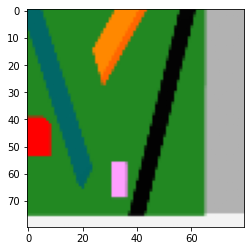

tensor([[ 5.0429, -5.3592],
        [ 5.0126, -5.7491],
        [-5.1408,  5.5935],
        [ 4.8153, -5.8749],
        [ 4.0373, -4.3654],
        [ 6.2585, -6.9222],
        [-7.2326,  6.2447],
        [ 4.9417, -5.9503],
        [ 4.0725, -5.1333],
        [ 5.8933, -6.7658]])


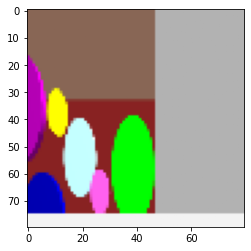

tensor([[ -5.7394,   6.2256],
        [ -6.5953,   5.3408],
        [  3.4397,  -3.5364],
        [-13.7136,  14.1731],
        [ -8.2915,   8.1323],
        [  2.9100,  -3.0290],
        [  3.6851,  -3.9907],
        [ -6.2896,   6.8198],
        [  5.3754,  -5.8490],
        [-20.7662,  20.7692]])


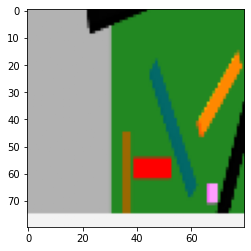

tensor([[  5.0408,  -6.0948],
        [  5.4626,  -6.2010],
        [  3.8655,  -4.1309],
        [ -9.8071,  10.0842],
        [-12.6826,  11.9292],
        [  6.1358,  -7.1097],
        [ -7.4772,   6.7208],
        [ -6.7333,   7.3063],
        [  5.4250,  -6.1768],
        [  5.1361,  -5.9665]])


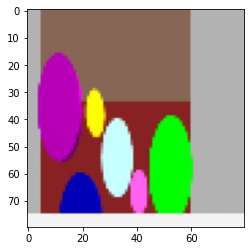

tensor([[ -7.3780,   7.1143],
        [ -6.1292,   4.7073],
        [  3.4280,  -4.0670],
        [ -4.7034,   5.0548],
        [-16.3242,  15.7340],
        [  5.4735,  -5.8216],
        [  4.9036,  -5.5448],
        [  4.1817,  -4.4722],
        [ -5.1435,   4.5772],
        [  4.2214,  -4.8557]])


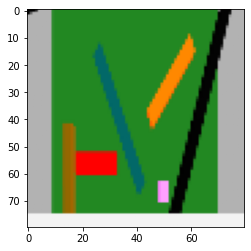

tensor([[  3.7153,  -3.9534],
        [  6.0776,  -6.8095],
        [  3.4857,  -3.7396],
        [  6.7075,  -7.6125],
        [ -5.3816,   5.4318],
        [-12.6535,  12.0186],
        [  3.7895,  -4.0573],
        [ -5.4352,   5.5940],
        [-13.5069,  12.7011],
        [ -7.7146,   6.7845]])


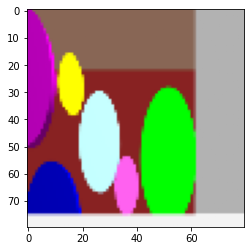

tensor([[ -6.3071,   6.3945],
        [ -6.5474,   7.0786],
        [ -6.9791,   7.3561],
        [-13.7181,  12.3677],
        [  5.1995,  -5.4850],
        [ -9.3916,   9.0132],
        [  4.2026,  -4.7306],
        [ -7.1470,   6.1806],
        [  4.3258,  -4.7561],
        [  3.8998,  -4.2351]])


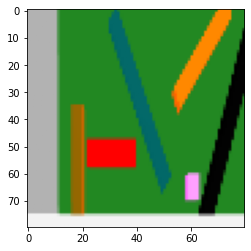

tensor([[  4.0227,  -4.4062],
        [-19.0191,  19.1772],
        [  6.1135,  -7.0699],
        [-16.3857,  15.0268],
        [-10.6019,  10.8159],
        [-11.3330,  11.0458],
        [-13.6198,  13.1122],
        [  6.3456,  -7.2779],
        [  4.5106,  -5.0303],
        [  4.7986,  -5.7296]])


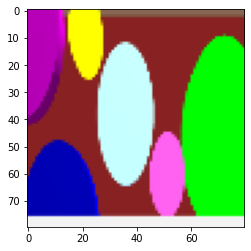

tensor([[-13.2369,  13.3380],
        [ -8.7455,   7.9469],
        [ -8.0412,   7.7006],
        [ -6.8877,   5.5431],
        [-12.1222,  12.8695],
        [ -6.9060,   7.2550],
        [-13.1214,  12.3349],
        [-22.1181,  21.5526],
        [  6.3128,  -6.9309],
        [  5.6994,  -6.3097]])


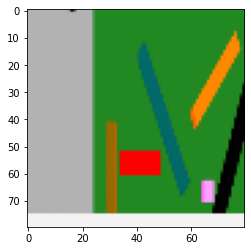

tensor([[  5.8895,  -6.7961],
        [  3.9158,  -4.3515],
        [  3.7821,  -4.0062],
        [-12.4243,  11.0716],
        [-16.1138,  16.1946],
        [  6.6488,  -7.3434],
        [  2.7513,  -3.0320],
        [  4.2877,  -4.4960],
        [ -9.6928,   8.6142],
        [  5.1949,  -5.8681]])


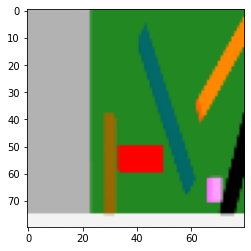

tensor([[  5.5218,  -6.3793],
        [ -6.2818,   6.3499],
        [  6.1495,  -7.0154],
        [  3.3028,  -3.5127],
        [-20.5744,  20.7680],
        [ -6.1566,   6.2793],
        [-13.0817,  12.4997],
        [  6.1195,  -6.7108],
        [  6.3677,  -7.3241],
        [  4.0518,  -4.3555]])


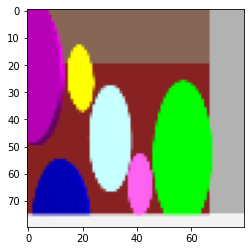

tensor([[ -8.8199,   8.5752],
        [  2.8228,  -2.6344],
        [  4.7014,  -5.0137],
        [  5.7286,  -6.2878],
        [  6.7542,  -7.4782],
        [ -8.6837,   7.5560],
        [  3.0641,  -3.2207],
        [-12.6616,  13.4605],
        [ -6.0223,   6.5447],
        [ -9.2699,   8.7901]])


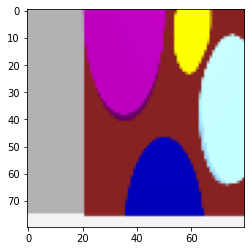

tensor([[-13.1170,  11.6423],
        [  2.4849,  -2.6604],
        [-18.1442,  17.0269],
        [  4.4920,  -4.7996],
        [  4.0240,  -4.2816],
        [  5.5521,  -6.3924],
        [ -4.6861,   2.8558],
        [  4.0080,  -4.5806],
        [  3.8587,  -4.1028],
        [  5.5627,  -6.4420]])


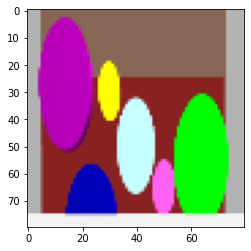

tensor([[ -6.4863,   5.1798],
        [ -3.3969,   3.5222],
        [ -6.7052,   5.4843],
        [-22.0052,  22.1802],
        [-11.6785,   9.9180],
        [  4.1460,  -4.5684],
        [  6.7713,  -7.6816],
        [  5.7127,  -6.6169],
        [-15.9712,  15.0592],
        [  6.0659,  -6.7244]])


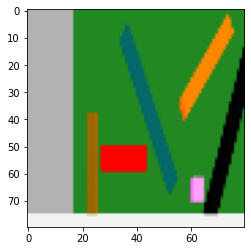

tensor([[  4.7820,  -5.4619],
        [  5.3653,  -6.0737],
        [ -9.7526,   9.3986],
        [-10.6800,   9.7118],
        [-14.7378,  15.8515],
        [ -6.5584,   6.8991],
        [ -6.4555,   5.0921],
        [ -9.0862,   7.2572],
        [ -9.0368,   9.1304],
        [ -5.1476,   5.5950]])


KeyboardInterrupt: 

In [11]:
with torch.no_grad():
    for img, label in test_loader:
        plt.imshow(img[0].squeeze().numpy().transpose(1,2,0))
        plt.show()
        out = net(img.to(device)).cpu()
        print(out)